<a href="https://colab.research.google.com/github/saquibali7/VideoFramePrediction/blob/main/FramePrediction1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import pickle
import numpy as np
from numpy import savez_compressed
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/t2_Videos_GAN'
data = os.listdir(data_path)

In [ ]:
image = list()
for i in range(200):
  count = 0
  cap= cv2.VideoCapture(os.path.join(data_path,data[i]))
  temp = []
  while(cap.isOpened()):
    ret, frame = cap.read()
    count+=1
    try:
      img = cv2.resize(frame, (256,256))
      temp.append(img)
    except:
      break
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break
  
  if len(temp) >= 40:
    for i in range(len(temp)-40):
      image.append(temp[i:40+i])
  
  cap.release()
  cv2.destroyAllWindows()    


In [ ]:
image = np.array(image)
print(image.shape)

(693, 40, 256, 256, 3)


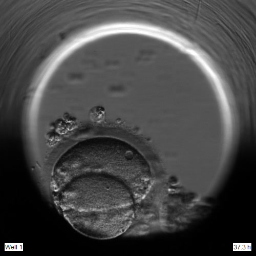

In [ ]:
idx = np.random.randint(0,len(image))
cv2_imshow(image[idx][39])

In [ ]:
%cd /content/drive/MyDrive
!mkdir framePrediction
%cd framePrediction
filename = '/content/drive/MyDrive/framePrediction/frames.npz'
savez_compressed(filename,image)

/content/drive/MyDrive
mkdir: cannot create directory ‘framePrediction’: File exists
/content/drive/MyDrive/framePrediction


NameError: ignored

In [5]:
%cd /content/drive/MyDrive/framePrediction

/content/drive/MyDrive/framePrediction


In [6]:
from numpy import load
frames = load('frames.npz')
train = frames['arr_0']
print(train.shape)

(693, 40, 256, 256, 3)


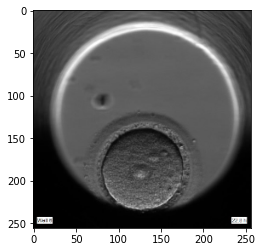

In [9]:
plt.imshow(train[0][0])

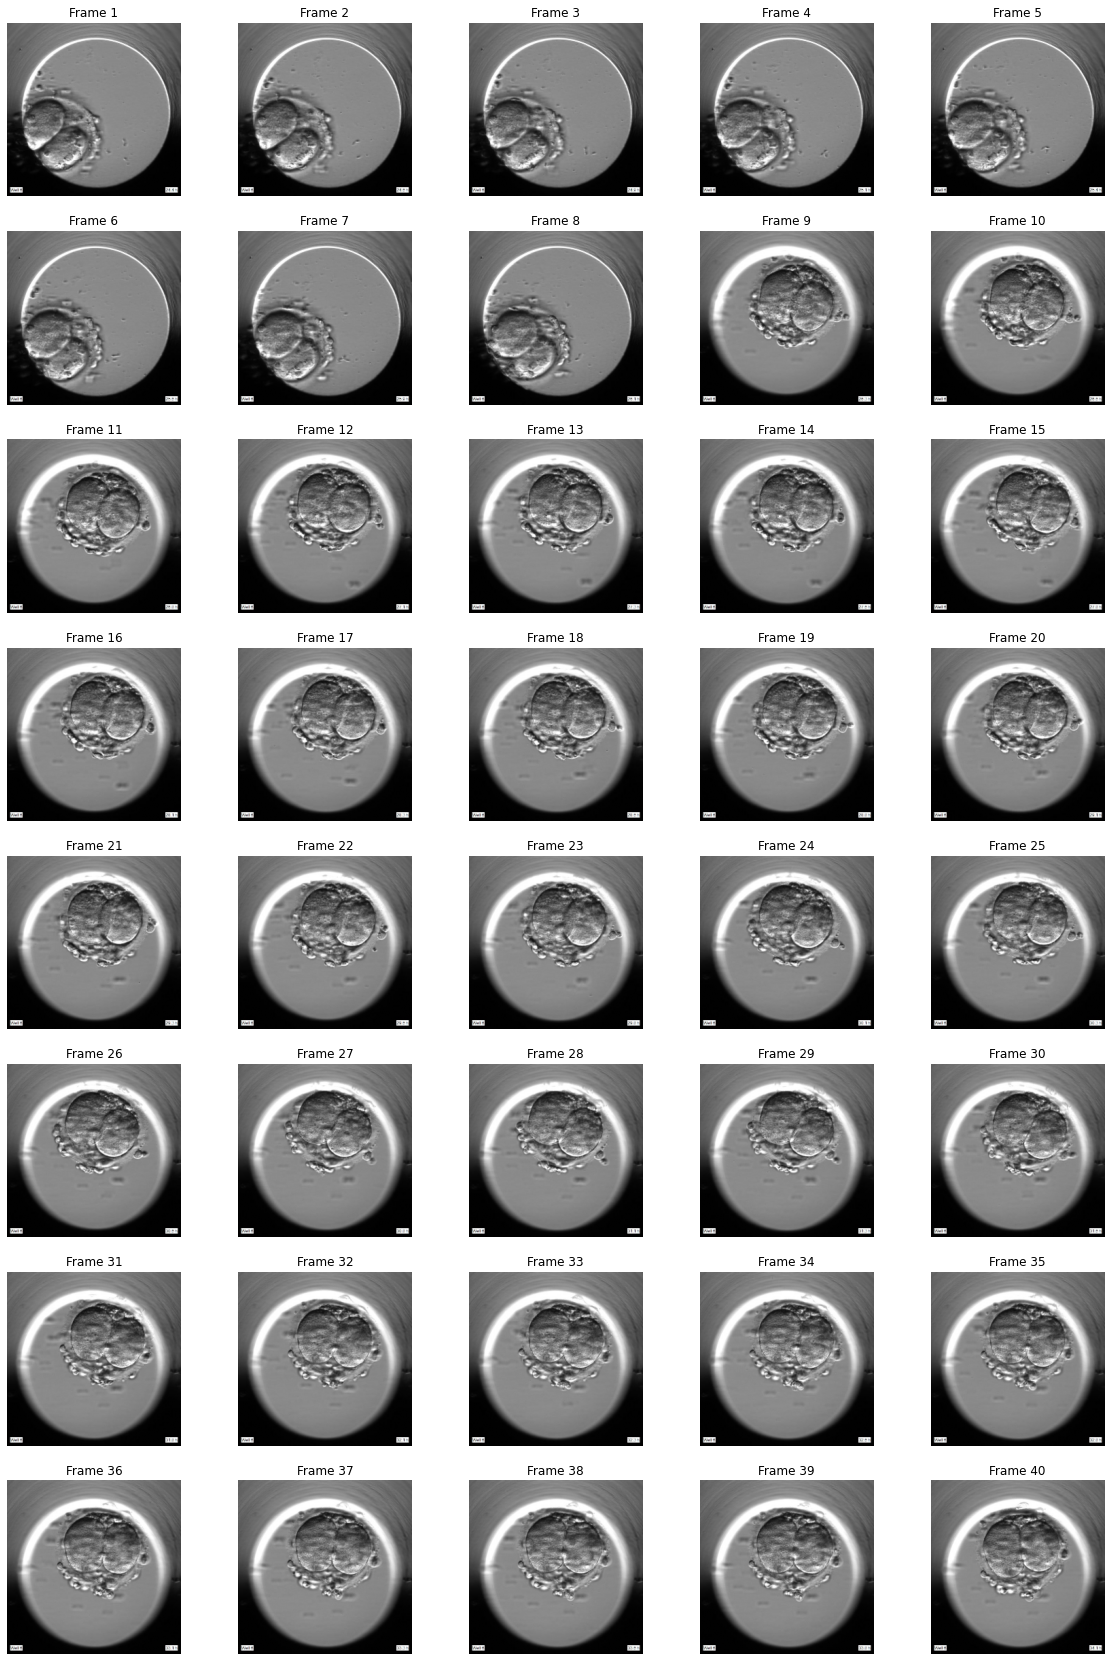

In [23]:
fig, axes = plt.subplots(8, 5, figsize=(20,30))
data_choice = np.random.choice(range(len(train)), size=1)[0]

for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train[data_choice][idx]/255.0), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

plt.show()

In [8]:
def create_dataset(frames):
  x = frames[:, 0:frames.shape[1]-1, :, :]
  y = frames[:, 1:frames.shape[1], :, :]
  return x, y

In [11]:
train_x, train_y = create_dataset(train)

In [1]:
train_x = train_x/255.0
train_y = train_y/255.0

NameError: ignored

In [12]:
print(train_x.shape, train_y.shape)

(693, 39, 256, 256, 3) (693, 39, 256, 256, 3)


In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
input = layers.Input(shape=(None, *train.shape[2:]))
x = layers.ConvLSTM2D(
    filters = 64, 
    kernel_size=(5,5),
    padding="same",
    return_sequences=True,    
    activation="relu"
    )(input)

x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters = 64,
    kernel_size=(3,3),
    padding = "same",
    return_sequences = True,
    activation = "relu"
    )(x)

x= layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters = 64,
    kernel_size = (1,1),
    padding = "same",
    return_sequences = True,
    activation = "relu"
    )(x)

x = layers.Conv3D(
    filters = 3, 
    kernel_size = (3, 3, 3),
    activation = "sigmoid",
    padding = "same"
    )(x)

model = keras.models.Model(input, x)
model.compile(
    loss=keras.losses.binary_crossentropy,
  optimizer=keras.optimizers.Adam(),
)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 256, 256,   0         
                             3)]                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 256, 256, 6  429056    
                             4)                                  
                                                                 
 batch_normalization (BatchN  (None, None, 256, 256, 6  256      
 ormalization)               4)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 256, 256, 6  295168    
                             4)                                  
                                                                 
 batch_normalization_1 (Batc  (None, None, 256, 256, 6  256  

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience = 5)

In [ ]:
epochs = 20
batch_size = 16

model.fit(
    train_x,
    train_y,
    batch_size = batch_size,
    epochs = epochs,
    validation_set = 0.1,
    callbacks = [early_stopping, reduce_lr],
)